<a href="https://colab.research.google.com/github/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/7506R_TP2_GRUPO09_ENTREGA_N0_(preprocesamiento).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Configuración Inicial

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importamos todos los módulos que se van a utilizar.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sklearn as sk
from sklearn.model_selection import (
    train_test_split
)
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest


dataset = pd.read_csv("/content/drive/MyDrive/OrgaTP2/properati_argentina_2021.csv")

SEMILLA = 0
TEST_SIZE = 0.2


## Separación Train-Test

Separamos el dataset en train-test.

In [ ]:
dataset_train, dataset_test = train_test_split(
    dataset, test_size=TEST_SIZE, random_state=SEMILLA
)

print("Proporción - Train: {:.2f}".format(dataset_train.shape[0] / dataset.shape[0]))
print("Proporción - Test: {:.2f}".format(dataset_test.shape[0] / dataset.shape[0]))


Proporción - Train: 0.80
Proporción - Test: 0.20


## Filtrado del set de Training

Eliminamos las observaciones y columnas que no nos van a interesar.

In [ ]:
def filtrado_columnas(dataset):
    filtro_tipo_propiedad = ["Casa", "PH", "Departamento"]
    filtro_operacion = ["Venta"]
    filtro_ubicacion = ["Capital Federal"]
    filtro_moneda = ["USD"]

    filtros = {
        "property_type": filtro_tipo_propiedad,
        "operation": filtro_operacion,
        "place_l2": filtro_ubicacion,
        "property_currency": filtro_moneda,
    }

    for columna_a_filtrar, filtro in filtros.items():
        dataset = dataset[dataset[columna_a_filtrar].isin(filtro)]

    return dataset

    
def eliminar_columnas(dataset):
    columnas_a_eliminar = {
        "property_title": [],
        "place_l4": [],
        "place_l5": [],
        "place_l6": [],
        "property_currency": [],
        "operation": [],
        "place_l2": [],
        "start_date": [],
        "end_date": [],
        "created_on": [], 
    }

    dataset.drop(columnas_a_eliminar, axis=1, inplace=True)

    return dataset

dataset_train = dataset_train.pipe(filtrado_columnas).pipe(eliminar_columnas)
dataset_test = dataset_test.pipe(filtrado_columnas).pipe(eliminar_columnas)

Renombramos `place_l3` a `barrio` para que sea más descriptivo.

In [ ]:
def renombrar_place_l3_a_barrio(dataset):
  return dataset.rename(columns={"place_l3": "barrio"})

dataset_train = dataset_train.pipe(renombrar_place_l3_a_barrio)
dataset_test = dataset_test.pipe(renombrar_place_l3_a_barrio)

Estandarizamos valores para dejar en NaN los datos que no tienen sentido y luego imputarlos.

In [ ]:
def estandarizar_barrio(dataset):
  dataset["barrio"] = dataset["barrio"].apply(
    lambda barrio: barrio if type(barrio) == str else None
  )

  return dataset

def estandarizar_superficie(fila):
    if fila["property_surface_total"] < 30:
      fila["property_surface_total"] = np.nan
    if fila["property_surface_covered"] < 30:
      fila["property_surface_covered"] = np.nan

    return fila

dataset_train = dataset_train.pipe(estandarizar_barrio).apply(estandarizar_superficie, axis=1)
dataset_test = dataset_test.pipe(estandarizar_barrio).apply(estandarizar_superficie, axis=1)

Observamos las características del dataset post filtrado.

In [ ]:
print(dataset_train.shape)
print(dataset_train.dtypes)

(75488, 10)
id                           object
latitud                     float64
longitud                    float64
barrio                       object
property_type                object
property_rooms              float64
property_bedrooms           float64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
dtype: object


 ## Análisis de Valores Atípicos Univariados

In [ ]:
columnas_cuantitativas = ["property_rooms", "property_bedrooms", "property_surface_total", "property_surface_covered", "property_price"]

def box_plot_cuantitativas(dataset_cuantitativo):
    figs, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 15))
    figs.tight_layout(pad=5)
    axes = np.ndarray.flatten(axes)
    for (i, columna) in enumerate(dataset_cuantitativo.columns):
        grafico = sns.boxplot(ax=axes[i], x=dataset_cuantitativo[columna])
        grafico.set(xlabel=columna)
        grafico.set(title=f"Distribución boxplot de {columna}")

Hacemos un boxplot de variables cuantitativas y vemos que hay muchos valores que salen del rango intercuartil. Al analizarlas con más detalle, vemos que son muestras que no tienen mucho sentido, como tener 70 cuartos.

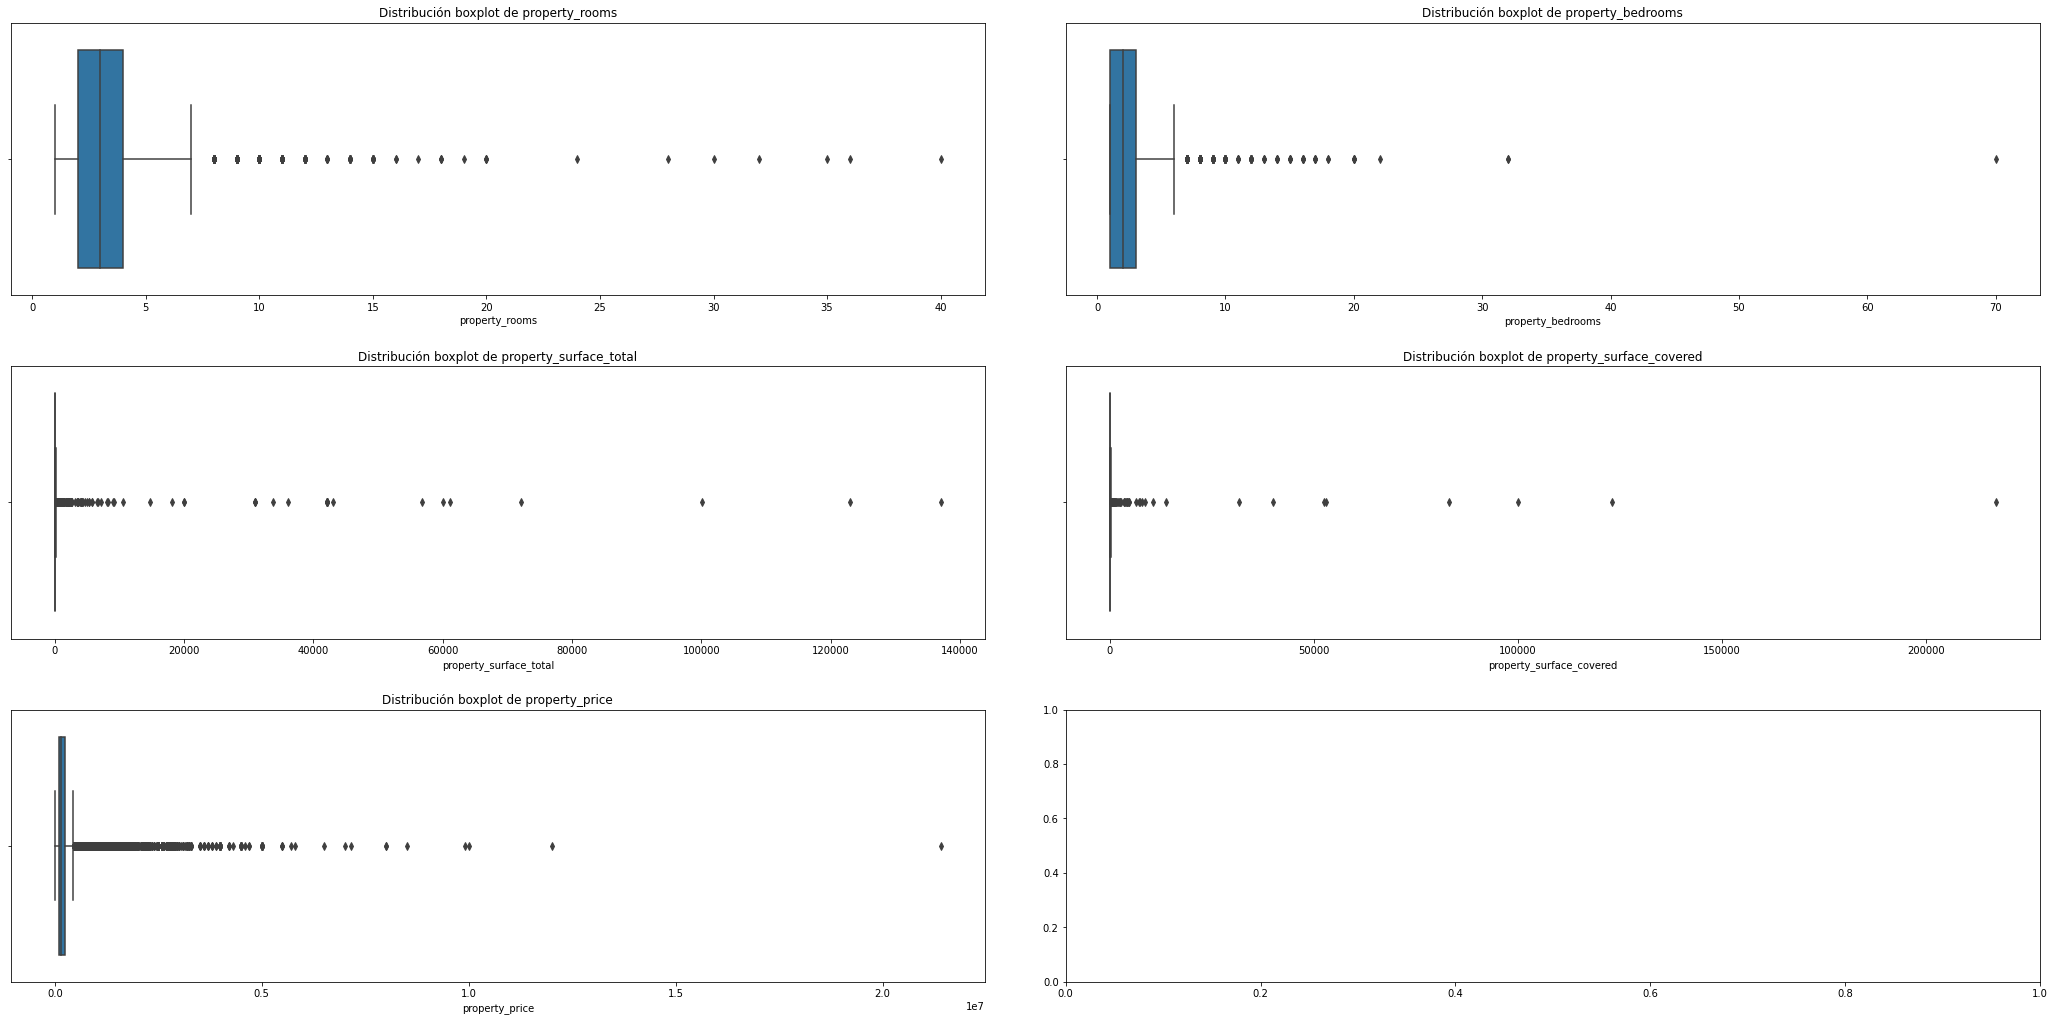

In [ ]:
box_plot_cuantitativas(dataset_train[columnas_cuantitativas])


Por lo tanto, eliminamos los outliers serveros con la técnica del rango intercuartil.

In [ ]:
def filtrar_columna_por_limites(dataset, col, inf, sup):
    a_filtrar = (dataset[col] > sup) | (
        dataset[col] < inf
    )
    return dataset[~a_filtrar]

for columna in columnas_cuantitativas:
    columna_q1 = dataset_train[columna].quantile(0.25)
    columna_q3 = dataset_train[columna].quantile(0.75)
    iqr = columna_q3 - columna_q1

    lim_superior = columna_q3 + (3 * iqr)
    lim_inferior = columna_q1 - (3 * iqr)

    dataset_train = dataset_train.pipe(filtrar_columna_por_limites, columna, lim_inferior, lim_superior)
    dataset_test = dataset_test.pipe(filtrar_columna_por_limites, columna, lim_inferior, lim_superior)

Boxplot post eliminación de outliers. Vemos que los valores que salen del rango intercuartil son menos extremos que antes, por lo que los dejamos para analizarlos con más detalle.

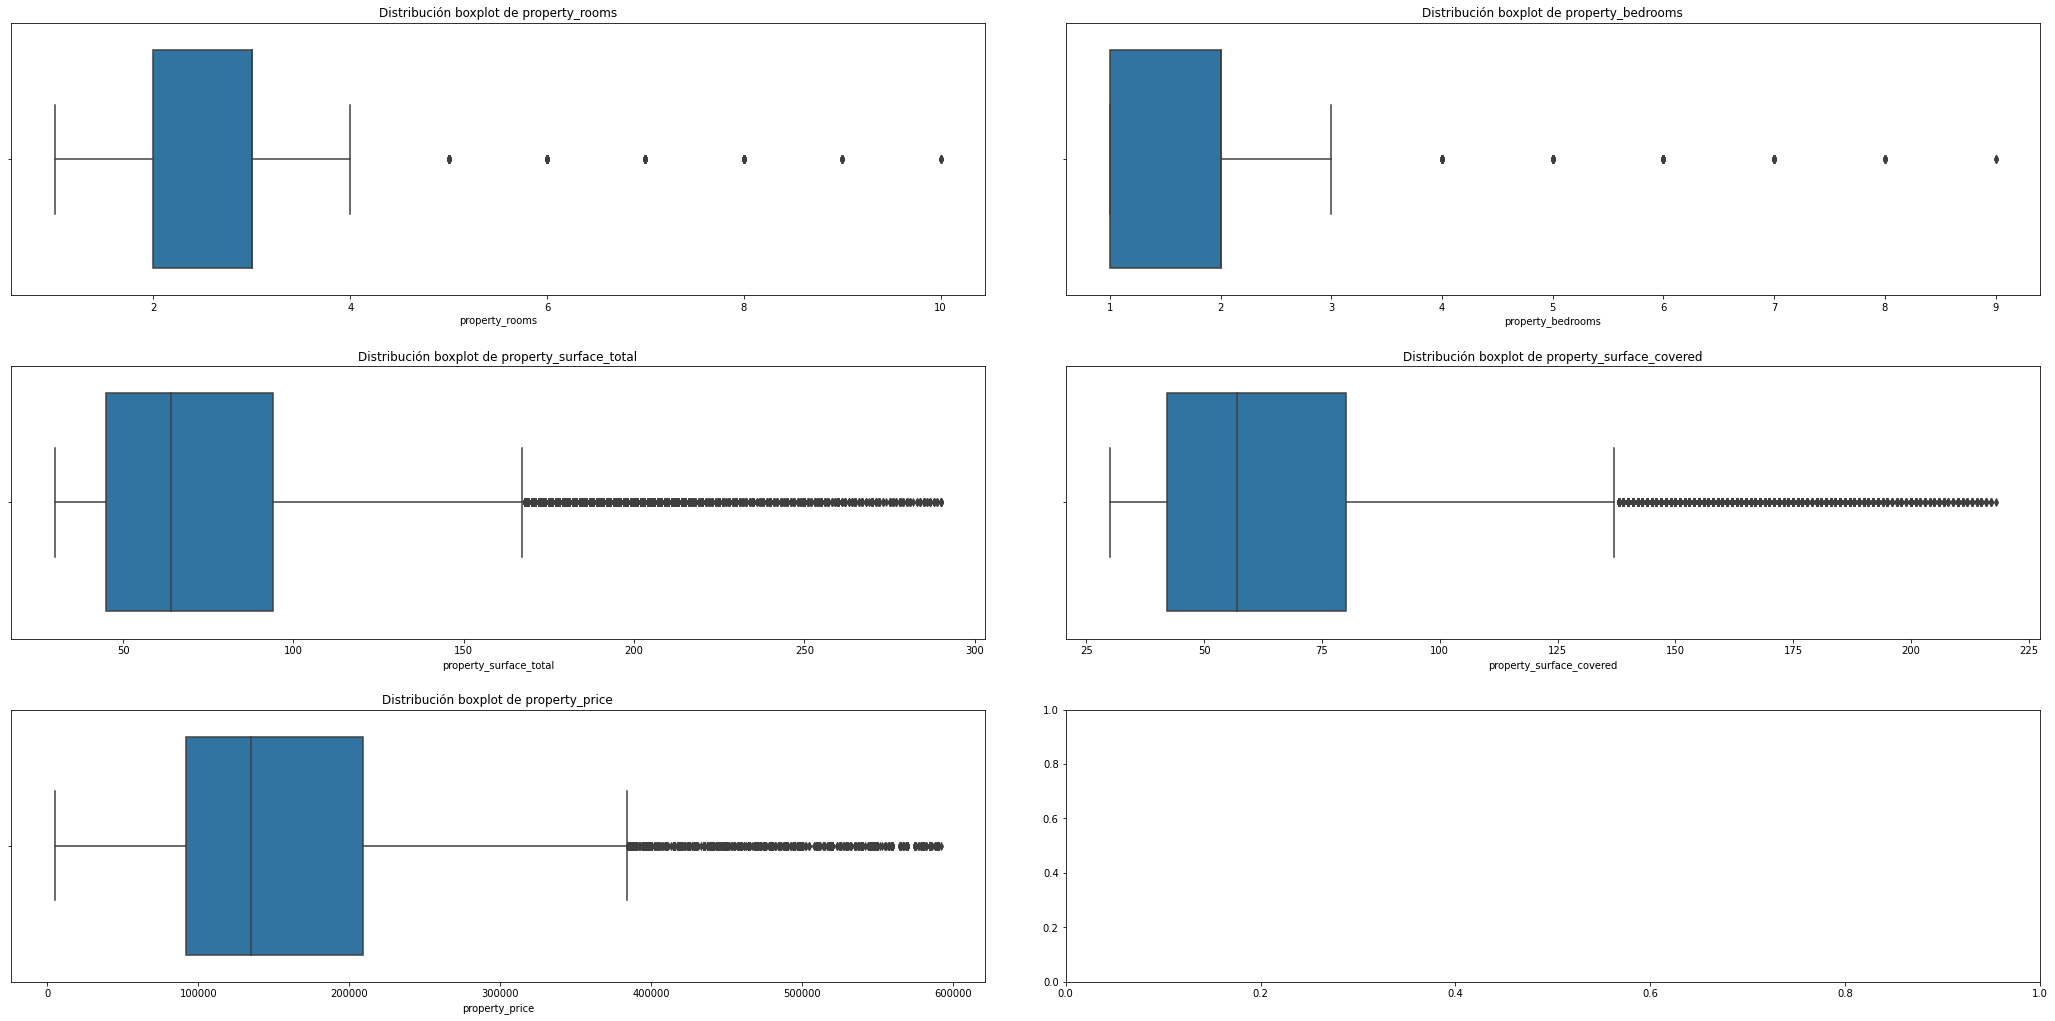

In [ ]:
box_plot_cuantitativas(dataset_train[columnas_cuantitativas])

Eliminamos casos atípicos donde se cumple que 
 - la superficie total es menor a la superficie cubierta
 - la cantidad de ambientes es menor a la cantidad de dormitorios 

In [ ]:
def eliminar_atipicos_manualmente(dataset):
  dataset = dataset[~(dataset.property_surface_covered > dataset.property_surface_total)]
  dataset = dataset[~(dataset.property_bedrooms > dataset.property_rooms)]
  return dataset

dataset_train = dataset_train.pipe(eliminar_atipicos_manualmente)
dataset_test = dataset_test.pipe(eliminar_atipicos_manualmente)


Estructura post eliminación de outliers.

In [ ]:
dataset_train.shape

(69657, 10)

## Imputación de datos faltantes

In [ ]:
def imputar_columnas(dataset, modelo, columnas):
    imputacion = modelo.transform(dataset[columnas])
    dataset_imputado = pd.DataFrame(imputacion, columns=columnas).astype(int)
    dataset[columnas] = dataset_imputado.values
    return dataset

### Imputación de `property_bedrooms`, `property_rooms`, `property_price`

Imputamos los datos utilizando un imputador iterativo.

In [ ]:
columnas = ["property_bedrooms", "property_rooms", "property_price"]

imp_ambientes_precio = IterativeImputer(
    estimator=LinearRegression(),
    missing_values=np.nan,
    min_value=(1, 1, 50000),
    max_iter=20,
    random_state=SEMILLA,
)
imp_ambientes_precio.fit(dataset_train[columnas])

IterativeImputer(estimator=LinearRegression(), max_iter=20,
                 min_value=(1, 1, 50000), random_state=0)

In [ ]:
dataset_train_imp = dataset_train.pipe(imputar_columnas, imp_ambientes_precio, columnas)
dataset_test_imp = dataset_test.pipe(imputar_columnas, imp_ambientes_precio, columnas)

Graficamos la distribución y vemos que luego de la imputación se mantuvo.

[Text(0.5, 0, 'precio de propiedad (usd)'),
 Text(0.5, 1.0, 'Distribución de precio de propiedad (imputado)')]

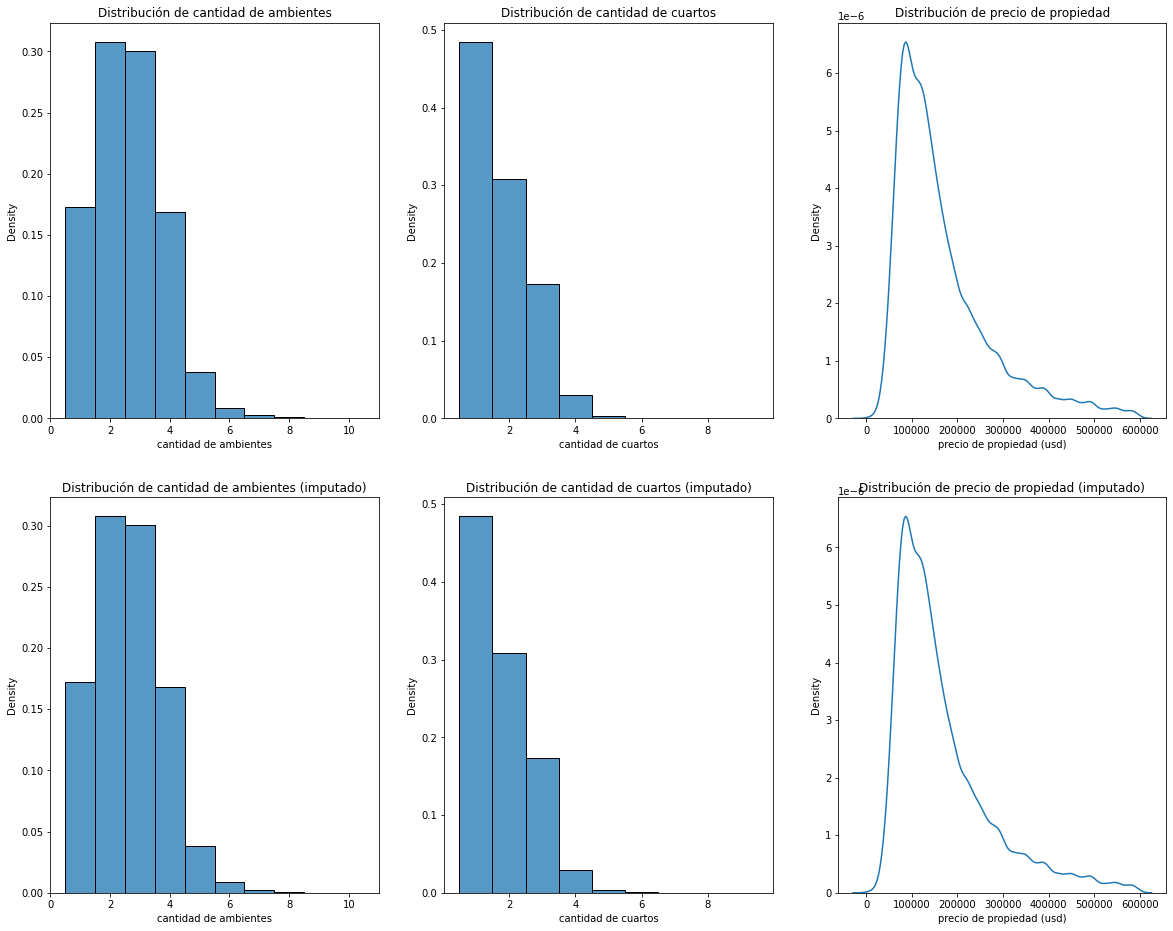

In [ ]:
figs, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 16))

ax = sns.histplot(
    ax=axes[0][0], x=dataset_train.property_rooms, discrete=True, stat="density"
)
ax.set(title="Distribución de cantidad de ambientes", xlabel="cantidad de ambientes")

ax = sns.histplot(
    ax=axes[0][1], x=dataset_train.property_bedrooms, discrete=True, stat="density"
)
ax.set(title="Distribución de cantidad de cuartos", xlabel="cantidad de cuartos")

ax = sns.kdeplot(ax=axes[0][2], x=dataset_train.property_price)
ax.set(title="Distribución de precio de propiedad", xlabel="precio de propiedad (usd)")

ax = sns.histplot(
    ax=axes[1][0], x=dataset_train_imp.property_rooms, discrete=True, stat="density"
)
ax.set(
    title="Distribución de cantidad de ambientes (imputado)",
    xlabel="cantidad de ambientes",
)

ax = sns.histplot(
    ax=axes[1][1], x=dataset_train_imp.property_bedrooms, discrete=True, stat="density"
)
ax.set(
    title="Distribución de cantidad de cuartos (imputado)", xlabel="cantidad de cuartos"
)

ax = sns.kdeplot(ax=axes[1][2], x=dataset_train_imp.property_price)
ax.set(
    title="Distribución de precio de propiedad (imputado)", xlabel="precio de propiedad (usd)"
)

Guardamos estos valores en el dataset con el que vamos a trabajar.

In [ ]:
dataset_train = dataset_train_imp.copy()
dataset_test = dataset_test_imp.copy()

dataset_train.isna().sum()

id                             0
latitud                     2596
longitud                    2596
barrio                       237
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total      5987
property_surface_covered    6490
property_price                 0
dtype: int64

### Imputación de `property_surface_covered`, `property_surface_total`


Imputamos los datos utilizando un imputador iterativo.

In [ ]:
columnas = ["property_surface_covered", "property_surface_total"]

imp_superficie = IterativeImputer(
    estimator=LinearRegression(),
    missing_values=np.nan,
    max_iter=20,
    min_value=(30, 30),
    verbose=0,
    random_state=SEMILLA,
)

imp_superficie.fit(dataset_train[columnas])

IterativeImputer(estimator=LinearRegression(), max_iter=20, min_value=(30, 30),
                 random_state=0)

In [ ]:
dataset_train_imp = dataset_train.pipe(imputar_columnas, imp_superficie, columnas)
dataset_test_imp = dataset_test.pipe(imputar_columnas, imp_superficie, columnas)

dataset_train.isna().sum()


id                             0
latitud                     2596
longitud                    2596
barrio                       237
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total         0
property_surface_covered       0
property_price                 0
dtype: int64

Graficamos la distribución y vemos nuevamente que se mantiene después de imputar los datos.

[Text(0.5, 0, 'superficie total (m2)'),
 Text(0.5, 1.0, 'Distribución de superficie total (imputado)')]

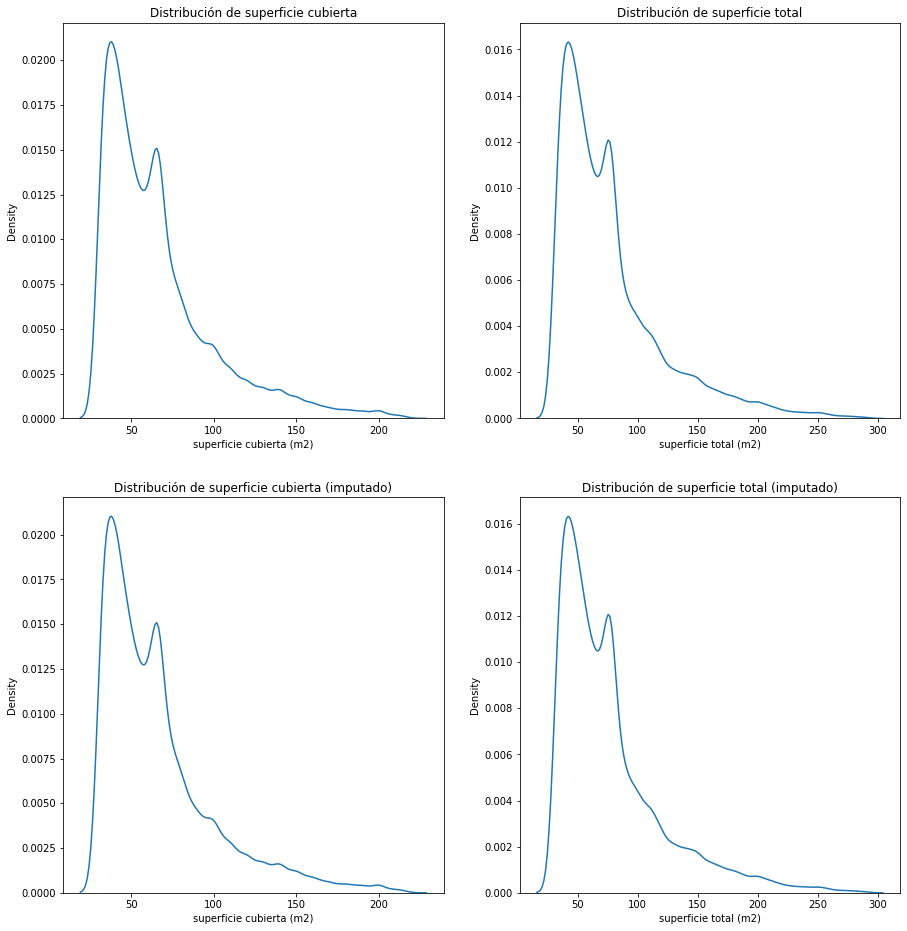

In [ ]:
figs, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 16))

ax = sns.kdeplot(ax=axes[0][0], x=dataset_train.property_surface_covered)
ax.set(title="Distribución de superficie cubierta", xlabel="superficie cubierta (m2)")

ax = sns.kdeplot(ax=axes[0][1], x=dataset_train.property_surface_total)
ax.set(title="Distribución de superficie total", xlabel="superficie total (m2)")

ax = sns.kdeplot(ax=axes[1][0], x=dataset_train_imp.property_surface_covered)
ax.set(
    title="Distribución de superficie cubierta (imputado)", xlabel="superficie cubierta (m2)"
)

ax = sns.kdeplot(ax=axes[1][1], x=dataset_train_imp.property_surface_total)
ax.set(title="Distribución de superficie total (imputado)", xlabel="superficie total (m2)")

Lo guardamos en el dataset original.

In [ ]:
dataset_train = dataset_train_imp.copy()
dataset_test = dataset_test_imp.copy()

dataset_train.isna().sum()

id                             0
latitud                     2596
longitud                    2596
barrio                       237
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total         0
property_surface_covered       0
property_price                 0
dtype: int64

### Imputacion `barrio` por `coordenadas`

Podemos entrenar un modelo que pueda predecir el barrio a partir de las coordenadas.

In [ ]:
dataset_imputacion_barrio = dataset_train.copy()
dataset_imputacion_barrio.dropna(inplace=True)

factorizacion_barrio = pd.factorize(dataset_imputacion_barrio["barrio"])
dataset_imputacion_barrio["barrio"] = factorizacion_barrio[0]
definiciones_barrio = factorizacion_barrio[1]

features = ["latitud", "longitud"]
target = "barrio"

X = dataset_imputacion_barrio[features]
y = dataset_imputacion_barrio[target]

imputador_barrio = DecisionTreeClassifier(
    random_state=SEMILLA,
)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEMILLA
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
imputador_barrio.fit(X_train, y_train)
print("Accuracy: ", imputador_barrio.score(X_test, y_test))

Accuracy:  0.8217673862702622


Vemos que tiene una buena performance, entonces lo usamos para imputar los barrios faltantes.

In [ ]:
def imputar_manual(fila, modelo, features, target, definiciones_target):
    if fila[target] != None:
        return fila

    if fila[features].isna().any():
        return fila

    pred = modelo.predict([fila[features].copy()])
    fila[target] = definiciones_target[pred[0]]

    return fila


dataset_train = dataset_train.apply(imputar_manual, axis=1, args=(imputador_barrio, features, target, definiciones_barrio))
dataset_test = dataset_test.apply(imputar_manual, axis=1, args=(imputador_barrio, features, target, definiciones_barrio))

Observamos la distribución de faltantes hasta ahora.

In [ ]:
dataset_train.isna().sum()


id                             0
latitud                     2596
longitud                    2596
barrio                       107
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total         0
property_surface_covered       0
property_price                 0
dtype: int64

### Imputación de `latitud`, `longitud` según `barrio`

Imputamos latitud y longitud con el promedio de su barrio.

In [ ]:
columnas_ubicacion = ["latitud", "longitud", "barrio"]
dataset_ubicaciones = dataset_train[columnas_ubicacion]
promedio_ubicaciones = dataset_ubicaciones.groupby("barrio").mean()


In [ ]:
def imputar_cordenadas(fila):
    barrio = fila["barrio"]

    if barrio == None:
        return fila

    if np.isnan(fila["latitud"]):
        fila["latitud"] = promedio_ubicaciones.at[barrio, "latitud"]

    if np.isnan(fila["longitud"]):
        fila["longitud"] = promedio_ubicaciones.at[barrio, "longitud"]

    return fila


dataset_train = dataset_train.apply(imputar_cordenadas, axis=1)
dataset_test = dataset_test.apply(imputar_cordenadas, axis=1)


Observamos la distribución de datos faltantes.

In [ ]:
dataset_train.isna().sum()


id                            0
latitud                     107
longitud                    107
barrio                      107
property_type                 0
property_rooms                0
property_bedrooms             0
property_surface_total        0
property_surface_covered      0
property_price                0
dtype: int64

### Datos Faltantes Restantes

Como quedan pocos datos que no se pueden imputar, los eliminamos para poder continuar con el análisis posterior.

In [ ]:
dataset_train = dataset_train[~dataset_train.barrio.isna()]
dataset_test = dataset_test[~dataset_test.barrio.isna()]


In [ ]:
dataset_train.isna().sum()


id                          0
latitud                     0
longitud                    0
barrio                      0
property_type               0
property_rooms              0
property_bedrooms           0
property_surface_total      0
property_surface_covered    0
property_price              0
dtype: int64

## Análisis de Valores Atípicos Multivariados

### Isolation Forest para `property_surface_total` y `property_price`

Analizamos valores atípicos con isolation forest.

In [ ]:
columnas = [
    "property_surface_total",
    "property_price",
]

dataset_isolation_forest = dataset_train[columnas].copy()
n_samples = dataset_isolation_forest.shape[0] // 4

iforest = IsolationForest(
    n_estimators=100,
    max_samples=n_samples,
    contamination=0.005,
    max_features=len(columnas),
    bootstrap=True,
    n_jobs=-1,
    random_state=SEMILLA,
)

dataset_isolation_forest["outlier"] = iforest.fit_predict(dataset_isolation_forest)
dataset_isolation_forest["outlier"] = dataset_isolation_forest["outlier"].replace(
    to_replace=[-1, 1], value=[True, False]
)

print("Cantidad de observaciones anómalas:")
print(dataset_isolation_forest["outlier"].value_counts())


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Cantidad de observaciones anómalas:
False    69202
True       348
Name: outlier, dtype: int64


Graficamos la distribución de outliers encontrada.

[Text(0, 0.5, 'property price (usd)'),
 Text(0.5, 0, 'property surface total (m^2)'),
 Text(0.5, 1.0, 'Distribución de superficie total vs precio')]

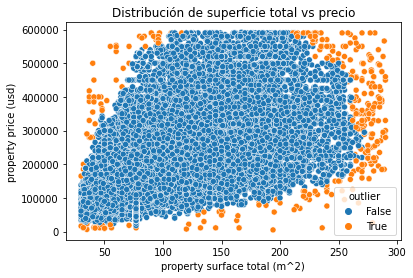

In [ ]:
sns.scatterplot(
    data=dataset_isolation_forest,
    x="property_surface_total",
    y="property_price",
    hue="outlier",
).set(title = "Distribución de superficie total vs precio", xlabel="property surface total (m^2)", ylabel="property price (usd)")

Como son pocas observaciones que van a alterar los resultados, las eliminamos.

In [ ]:
dataset_train = dataset_train[~dataset_isolation_forest.outlier]
dataset_train.shape



(69202, 10)

## Exportación

Exportamos los datasets luego de aplicar el preprocesamiento de datos.

In [ ]:
!mkdir datasets

In [ ]:
dataset_train.to_csv("datasets/dataset_train_preprocesado.csv")
dataset_test.to_csv("datasets/datasetc_test_preprocesado.csv")

## Construcción de Feature y Target

### Clasificación

In [ ]:
clasificacion_train = dataset_train.copy()
clasificacion_test = dataset_test.copy()

In [ ]:
def agregar_pxm2(dataset):
  dataset["pxm2"] = dataset.property_price / dataset.property_surface_total

  return dataset

clasificacion_train = clasificacion_train.pipe(agregar_pxm2)
clasificacion_test = clasificacion_test.pipe(agregar_pxm2)

In [ ]:
def categorizar_pxm2(fila, umbrales, labels):
  for i in range(len(umbrales)):
    if fila["pxm2"] <= umbrales[i]:
      fila["tipo_precio"] = labels[i]
      return fila

labels = ["bajo", "medio", "alto"]
umbrales = pd.qcut(clasificacion_train.pxm2,  q=[0, 1 / 3, 2 / 3, 1], retbins=True)[1][1:]
umbrales[2] = np.inf

clasificacion_train = clasificacion_train.apply(categorizar_pxm2, args=(umbrales, labels), axis=1)
clasificacion_test = clasificacion_test.apply(categorizar_pxm2, args=(umbrales, labels), axis=1)

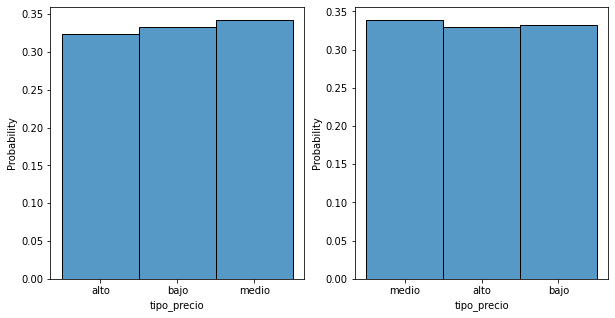

In [ ]:
figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.histplot(ax = axes[0], data=clasificacion_train, x="tipo_precio", stat="probability")
sns.histplot(ax = axes[1], data=clasificacion_test, x="tipo_precio", stat="probability")

In [ ]:
def construir_feature_target(dataset):
  feature = dataset.drop(["property_price", "pxm2", "tipo_precio"], axis=1)
  feature = pd.get_dummies(feature, columns=["barrio", "property_type"], drop_first=True)
  target = dataset["tipo_precio"]

  return (feature, target)


clasificacion_train_feature, clasificacion_train_target = clasificacion_train.pipe(construir_feature_target)
clasificacion_test_feature, clasificacion_test_target = clasificacion_test.pipe(construir_feature_target)

print("== Feature ==\n")
print(clasificacion_train_feature.dtypes)
print("\n== Target ==\n")
print(clasificacion_train_target.dtypes)

== Feature ==

id                             object
latitud                       float64
longitud                      float64
property_rooms                  int64
property_bedrooms               int64
                               ...   
barrio_Villa Soldati            uint8
barrio_Villa Urquiza            uint8
barrio_Villa del Parque         uint8
property_type_Departamento      uint8
property_type_PH                uint8
Length: 65, dtype: object

== Target ==

object


In [ ]:
def insertar_columnas_faltantes(dataset_test, dataset_train):
    for (i, columna) in enumerate(dataset_train.columns):
        if not columna in dataset_test.columns.unique():
            dataset_test.insert(i, columna, 0)

    return dataset_test

clasificacion_test_feature = insertar_columnas_faltantes(clasificacion_test_feature, clasificacion_train_feature)
clasificacion_train_feature = insertar_columnas_faltantes(clasificacion_train_feature, clasificacion_test_feature)


In [ ]:
clasificacion_train_feature.to_csv("datasets/clasificacion_train_feature.csv")
clasificacion_train_target.to_csv("datasets/clasificacion_train_target.csv")
clasificacion_test_feature.to_csv("datasets/clasificacion_test_feature.csv")
clasificacion_test_target.to_csv("datasets/clasificacion_test_target.csv")

### Regresión


In [ ]:
regresion_train = dataset_train.copy()
regresion_test = dataset_test.copy()

In [ ]:
def construir_feature_target(dataset):
  feature = dataset.drop(["property_price"], axis=1)
  feature = pd.get_dummies(feature, columns=["barrio", "property_type"], drop_first=True)
  target =dataset["property_price"]

  return (feature, target)


regresion_train_feature, regresion_train_target = regresion_train.pipe(construir_feature_target)
regresion_test_feature, regresion_test_target = regresion_test.pipe(construir_feature_target)

print("== Feature ==\n")
print(regresion_train_feature.dtypes)
print("\n== Target ==\n")
print(regresion_train_target.dtypes)

== Feature ==

id                             object
latitud                       float64
longitud                      float64
property_rooms                  int64
property_bedrooms               int64
                               ...   
barrio_Villa Soldati            uint8
barrio_Villa Urquiza            uint8
barrio_Villa del Parque         uint8
property_type_Departamento      uint8
property_type_PH                uint8
Length: 65, dtype: object

== Target ==

int64


In [ ]:
def insertar_columnas_faltantes(dataset_test, dataset_train):
    for (i, columna) in enumerate(dataset_train.columns):
        if not columna in dataset_test.columns.unique():
            dataset_test.insert(i, columna, 0)

    return dataset_test

regresion_test_feature = insertar_columnas_faltantes(regresion_test_feature, regresion_train_feature)
regresion_train_feature = insertar_columnas_faltantes(regresion_train_feature, regresion_test_feature)

In [ ]:
regresion_train_feature.to_csv("datasets/regresion_train_feature.csv")
regresion_train_target.to_csv("datasets/regresion_train_target.csv")
regresion_test_feature.to_csv("datasets/regresion_test_feature.csv")
regresion_test_target.to_csv("datasets/regresion_test_target.csv")

### Descarga

In [ ]:
!zip -r /content/datasets.zip /content/datasets

  adding: content/datasets/ (stored 0%)
  adding: content/datasets/clasificacion_train_target.csv (deflated 68%)
  adding: content/datasets/regresion_train_feature.csv (deflated 77%)
  adding: content/datasets/regresion_test_target.csv (deflated 61%)
  adding: content/datasets/regresion_test_feature.csv (deflated 77%)
  adding: content/datasets/regresion_train_target.csv (deflated 61%)
  adding: content/datasets/clasificacion_test_feature.csv (deflated 77%)
  adding: content/datasets/datasetc_test_preprocesado.csv (deflated 57%)
  adding: content/datasets/clasificacion_train_feature.csv (deflated 77%)
  adding: content/datasets/dataset_train_preprocesado.csv (deflated 57%)
  adding: content/datasets/clasificacion_test_target.csv (deflated 68%)


In [ ]:
from google.colab import files
files.download("/content/datasets.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>